In [ ]:
!pip install factor_analyzer # https://pypi.org/project/factor-analyzer/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# 필요한 패키지/모듈 가져오기
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline

from factor_analyzer import FactorAnalyzer
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# raw data 바꿔가면서 분석
raw_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/데이터.csv', index_col = 0, encoding = 'cp949')
raw_data = raw_data.drop("REFYM", axis = 1)

# 분석에 이용할 컬럼 바꾸고 싶으면 meaning list 수정
meaning_list_app = raw_data.columns.tolist()[48:]
meaning_list = ['승차인원','하차인원','단독주택','미등록','공동주택','제1종근린생활시설','제2종근린생활시설','업무시설','의료시설','노유자시설','종교시설','교육연구시설','자동차관련시설','창고시설','문화및집회시설','공장','위험물저장및처리시설','동.식물관련시설','판매시설','숙박시설','운동시설','분뇨.쓰레기처리시설','자원순환관련시설','근린생활시설','방송통신시설','교육연구및복지시설','운수시설','판매및영업시설','위락시설','교정및군사시설','수련시설',
 '장례시설','발전시설','공공용시설','관광휴게시설','야영장시설','묘지관련시설','다세대주택']
data= raw_data.loc[:, meaning_list]
data = data.dropna(axis=0)

#클러스터링 포함
cl_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/클러스터데이터1.csv', index_col = 0, encoding = 'cp949')
data = data.loc[cl_data.index.tolist(), :]
data['유동인구'] = data['승차인원'] + data['하차인원']
data = data.drop(['승차인원','하차인원'], axis = 1)
data

단독주택    미등록   공동주택  제1종근린생활시설  제2종근린생활시설  업무시설  의료시설  노유자시설  종교시설  \
가평역     77.0  886.0   20.0       18.0       51.0   0.0   0.0    1.0   1.0   
강매역     52.0  263.0  172.0       34.0       11.0   0.0   0.0    1.0   2.0   
개화역    226.0  352.0    4.0       22.0        4.0   0.0   0.0    2.0   6.0   
검암역     71.0  300.0  140.0       41.0       43.0   0.0   0.0    1.0   2.0   
경기광주역  163.0  410.0  108.0       33.0       29.0   0.0   0.0    0.0   1.0   
...      ...    ...    ...        ...        ...   ...   ...    ...   ...   
초지역      2.0  233.0   68.0        6.0        5.0   1.0   0.0    0.0   1.0   
파주역    108.0  604.0    8.0       16.0       25.0   0.0   0.0    0.0   0.0   
팔당역     77.0  519.0    2.0       10.0       42.0   0.0   0.0    1.0   0.0   
행신역    105.0  164.0   49.0       25.0       23.0   9.0   0.0    1.0   2.0   
화전역    310.0  715.0    3.0       99.0       50.0   0.0   0.0    2.0   1.0   

       교육연구시설  ...  교정및군사시설  수련시설  장례시설  발전시설  공공용시설  관광휴게시설  야영장시설  묘지관련시설  \
가평역      42.0  ...      0.0   0.0   0.0   0.0    0.0     0.0    0.0     0.0   
강매역       9.0  ...      0.0   0.0   0.0   0.0    0.0     0.0    0.0     0.0   
개화역       0.0  ...      0.0   0.0   0.0   0.0    0.0     0.0    0.0     0.0   
검암역       5.0  ...      0.0   0.0   0.0   0.0    0.0     0.0    0.0     0.0   
경기광주역   142.0  ...      0.0   0.0   0.0   0.0    0.0     0.0    0.0     0.0   
...       ...  ...      ...   ...   ...   ...    ...     ...    ...     ...   
초지역      47.0  ...      0.0   0.0   0.0   0.0    0.0    24.0    0.0     0.0   
파주역       0.0  ...      0.0   0.0   0.0   0.0    0.0     0.0    0.0     0.0   
팔당역       1.0  ...      0.0   0.0   0.0   0.0    0.0     0.0    0.0     0.0   
행신역       6.0  ...      0.0   0.0   0.0   0.0    0.0     0.0    0.0     1.0   
화전역     281.0  ...    504.0   0.0   0.0   0.0    0.0     0.0    0.0     0.0   

       다세대주택      유동인구  
가평역      0.0  173530.0  
강매역      0.0  314044.0  
개화역      0.0  221664.0  
검암역      0.0  715334.0  
경기광주역    0.0  795054.0  
...      ...       ...  
초지역      0.0  507050.0  
파주역      0.0  121484.0  
팔당역      0.0  104632.0  
행신역      0.0  843118.0  
화전역      0.0  190018.0  

[93 rows x 37 columns]

전처리

In [ ]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

In [ ]:
# 주변 건물의 수는 배제 (이상치 너무 많음) 후 이상치 탐지
for col in data.columns.tolist()[0:6]:
    outlier_idx = get_outlier(df=data, column=col, weight=1.5)
    data.drop(outlier_idx, axis=0, inplace=True)

In [ ]:
train_dataset, test_dataset = train_test_split(data, train_size=0.7, test_size=0.3,random_state=311)

In [ ]:
train_y = train_dataset[['유동인구']]
test_y = test_dataset[['유동인구']]
train = train_dataset.drop(['유동인구'], axis=1)
test = test_dataset.drop(['유동인구'], axis=1)

주성분 회귀분석

In [ ]:
from sklearn.preprocessing import StandardScaler
scale_train = pd.DataFrame(StandardScaler().fit_transform(train), columns=train.columns, index = train.index)
scale_train.mean(axis=0)

단독주택          5.046468e-17
미등록           5.046468e-18
공동주택          1.640102e-17
제1종근린생활시설    -6.055762e-17
제2종근린생활시설    -1.160688e-16
업무시설          0.000000e+00
의료시설         -1.009294e-17
노유자시설        -4.037175e-17
종교시설         -9.083643e-17
교육연구시설       -2.270911e-17
자동차관련시설      -7.569702e-18
창고시설         -6.308085e-17
문화및집회시설       1.261617e-17
공장           -1.766264e-17
위험물저장및처리시설   -2.018587e-17
동.식물관련시설      1.009294e-17
판매시설          5.046468e-17
숙박시설         -1.513940e-17
운동시설          3.027881e-17
분뇨.쓰레기처리시설   -1.261617e-17
자원순환관련시설     -3.532528e-17
근린생활시설       -6.055762e-17
방송통신시설       -8.074349e-17
교육연구및복지시설     1.236385e-16
운수시설         -2.523234e-18
판매및영업시설       0.000000e+00
위락시설         -4.541821e-17
교정및군사시설      -1.387779e-17
수련시설         -3.532528e-17
장례시설          0.000000e+00
발전시설         -7.065056e-17
공공용시설         0.000000e+00
관광휴게시설       -2.397072e-17
야영장시설        -3.532528e-17
묘지관련시설        0.000000e+00
다세대주택        -3.658690e-17
dtype: float64

In [ ]:
from sklearn.preprocessing import StandardScaler
scale_test = pd.DataFrame(StandardScaler().fit_transform(test), columns=test.columns, index = test.index)
scale_test.mean(axis=0)

단독주택         -7.216450e-17
미등록          -1.110223e-17
공동주택         -2.775558e-17
제1종근린생활시설    -4.440892e-17
제2종근린생활시설     0.000000e+00
업무시설         -2.220446e-17
의료시설         -3.885781e-17
노유자시설        -2.220446e-17
종교시설          6.938894e-19
교육연구시설       -5.551115e-17
자동차관련시설      -2.220446e-17
창고시설         -2.220446e-17
문화및집회시설      -3.053113e-17
공장            0.000000e+00
위험물저장및처리시설    3.330669e-17
동.식물관련시설     -5.551115e-17
판매시설          7.771561e-17
숙박시설         -1.665335e-17
운동시설         -8.881784e-17
분뇨.쓰레기처리시설    0.000000e+00
자원순환관련시설      2.220446e-17
근린생활시설        2.220446e-17
방송통신시설       -1.387779e-17
교육연구및복지시설    -3.885781e-17
운수시설         -7.771561e-17
판매및영업시설       0.000000e+00
위락시설         -1.026956e-16
교정및군사시설      -2.220446e-17
수련시설          0.000000e+00
장례시설          0.000000e+00
발전시설          0.000000e+00
공공용시설         0.000000e+00
관광휴게시설        1.942890e-17
야영장시설        -3.608225e-17
묘지관련시설       -3.330669e-17
다세대주택        -5.828671e-17
dtype: float64

In [ ]:
scale_train.cov()

단독주택       미등록      공동주택  제1종근린생활시설  제2종근린생활시설      업무시설  \
단독주택        1.023256  0.221619  0.062781   0.458230   0.635244  0.064190   
미등록         0.221619  1.023256 -0.412809   0.151652   0.258176 -0.240474   
공동주택        0.062781 -0.412809  1.023256   0.253169   0.277608  0.512218   
제1종근린생활시설   0.458230  0.151652  0.253169   1.023256   0.650621  0.168623   
제2종근린생활시설   0.635244  0.258176  0.277608   0.650621   1.023256  0.171116   
업무시설        0.064190 -0.240474  0.512218   0.168623   0.171116  1.023256   
의료시설        0.047988 -0.291710  0.129865  -0.037537  -0.013255  0.423090   
노유자시설       0.355140 -0.069814  0.207564   0.285488   0.272390  0.216868   
종교시설        0.330821 -0.224133  0.543165   0.130521   0.203666  0.306549   
교육연구시설      0.370024  0.099078  0.068166   0.550528   0.143125 -0.078017   
자동차관련시설    -0.060920 -0.066428 -0.133418   0.107675   0.046977  0.072916   
창고시설        0.033728  0.302088 -0.047433   0.059187   0.264044 -0.156642   
문화및집회시설    -0.059048 -0.029869 -0.052451  -0.076328   0.030482 -0.058273   
공장         -0.020465  0.140066 -0.108877   0.094037   0.035541  0.133116   
위험물저장및처리시설  0.469303  0.040133 -0.019525   0.401352   0.596149  0.107417   
동.식물관련시설   -0.037776  0.251227 -0.206681   0.066525   0.066474 -0.083012   
판매시설        0.053488 -0.179649  0.200192   0.102027  -0.070093  0.119351   
숙박시설       -0.067119 -0.009738 -0.046835   0.252594   0.236689  0.013616   
운동시설        0.190713 -0.189641 -0.031812   0.165070   0.122676  0.153650   
분뇨.쓰레기처리시설 -0.146685 -0.033634 -0.246130  -0.187552  -0.229943 -0.159487   
자원순환관련시설   -0.127833 -0.008694 -0.141882  -0.077972  -0.182481 -0.096858   
근린생활시설      0.120804  0.059690  0.033768   0.138420   0.238624  0.165393   
방송통신시설     -0.066793  0.256209 -0.158422  -0.023804  -0.012600 -0.114626   
교육연구및복지시설   0.278135 -0.175096  0.131530   0.216100   0.135224  0.226313   
운수시설        0.022935  0.110658 -0.014539  -0.084030   0.063712 -0.125055   
판매및영업시설     0.000000  0.000000  0.000000   0.000000   0.000000  0.000000   
위락시설       -0.037636  0.099888 -0.081924   0.160829   0.143576  0.015293   
교정및군사시설     0.267668  0.192584 -0.121195   0.589164   0.124224 -0.093849   
수련시설       -0.098237 -0.043468 -0.103509   0.192669   0.075648 -0.096858   
장례시설        0.000000  0.000000  0.000000   0.000000   0.000000  0.000000   
발전시설       -0.026197 -0.227151 -0.089039  -0.144118  -0.159059  0.147977   
공공용시설       0.000000  0.000000  0.000000   0.000000   0.000000  0.000000   
관광휴게시설      0.148932 -0.253635  0.015858   0.075951  -0.046394 -0.020640   
야영장시설       0.114572  0.062275  0.102746  -0.014292   0.007719 -0.096858   
묘지관련시설      0.000000  0.000000  0.000000   0.000000   0.000000  0.000000   
다세대주택      -0.070050  0.114792 -0.096314  -0.101852  -0.046624 -0.096858   

                의료시설     노유자시설      종교시설    교육연구시설  ...      위락시설   교정및군사시설  \
단독주택        0.047988  0.355140  0.330821  0.370024  ... -0.037636  0.267668   
미등록        -0.291710 -0.069814 -0.224133  0.099078  ...  0.099888  0.192584   
공동주택        0.129865  0.207564  0.543165  0.068166  ... -0.081924 -0.121195   
제1종근린생활시설  -0.037537  0.285488  0.130521  0.550528  ...  0.160829  0.589164   
제2종근린생활시설  -0.013255  0.272390  0.203666  0.143125  ...  0.143576  0.124224   
업무시설        0.423090  0.216868  0.306549 -0.078017  ...  0.015293 -0.093849   
의료시설        1.023256 -0.017100  0.341014 -0.021845  ... -0.034052 -0.034872   
노유자시설      -0.017100  1.023256  0.173908  0.116929  ... -0.049508  0.026224   
종교시설        0.341014  0.173908  1.023256  0.051832  ... -0.103084 -0.039360   
교육연구시설     -0.021845  0.116929  0.051832  1.023256  ... -0.024343  0.784884   
자동차관련시설     0.074393 -0.052848 -0.096452 -0.160216  ... -0.077492 -0.078331   
창고시설       -0.114052 -0.035432 -0.143141 -0.162522  ...  0.004030 -0.096521   
문화및집회시설    -0.070772 -0.035481 -0.085238  0.011291  ... -0.049458 -0.050650   
공장          0.041225  0.195665  0.096957 -0.088735  ... -0.064175 -0.050445   
위험물저장및처리시설  0.0205

In [ ]:
pca = PCA(random_state=312)
X_p = pca.fit_transform(scale_train)

In [ ]:
t = 6 #pc 개수 조정
pca = PCA(n_components=t,random_state=312)
x_p = pca.fit_transform(scale_train)

In [ ]:
pc_list = []
for i in range(0,t):
  pc_list.append(f"PC{i+1}")

pd.DataFrame(pca.components_.T, 
             columns = pc_list, 
             index=scale_train.columns)

PC1       PC2       PC3           PC4           PC5  \
단독주택        3.204346e-01 -0.181867  0.077068  7.426763e-03 -1.617687e-01   
미등록        -6.268287e-02 -0.344199  0.247474 -4.013329e-02 -8.675009e-02   
공동주택        2.162620e-01  0.105755 -0.338462 -5.650189e-02 -1.529837e-01   
제1종근린생활시설   3.429066e-01 -0.261785  0.084222 -2.457045e-02  7.475934e-02   
제2종근린생활시설   2.952034e-01 -0.330361 -0.070529  2.985398e-02 -2.147343e-02   
업무시설        1.905796e-01  0.093922 -0.348944  1.076427e-01 -9.200582e-02   
의료시설        8.736098e-02  0.110356 -0.274994  4.042211e-02 -8.321971e-02   
노유자시설       2.179401e-01 -0.050104 -0.073751  1.214303e-01 -1.523333e-01   
종교시설        1.906684e-01  0.038180 -0.324597 -2.686426e-02 -1.991144e-01   
교육연구시설      2.740567e-01 -0.024190  0.324064 -1.421984e-01 -6.275365e-02   
자동차관련시설     3.158331e-02 -0.036548 -0.103441 -1.719300e-02  2.166937e-01   
창고시설       -4.640335e-02 -0.241874  0.049028  1.144856e-01 -1.697273e-01   
문화및집회시설     5.766998e-03  0.089219  0.082259 -8.154095e-02  6.037462e-02   
공장         -2.245232e-03 -0.116626 -0.053604  3.311203e-01 -1.761695e-01   
위험물저장및처리시설  1.959790e-01 -0.258280 -0.034929  4.141394e-02  8.148978e-03   
동.식물관련시설   -7.755516e-02 -0.168671  0.126932 -6.696161e-02 -1.688796e-02   
판매시설        1.980847e-01  0.242525  0.154447  1.556337e-01  6.453796e-02   
숙박시설        2.636253e-02 -0.180998 -0.160273  9.778037e-02  5.482574e-01   
운동시설        2.587163e-01  0.241944  0.144481  2.291681e-01  5.647307e-02   
분뇨.쓰레기처리시설 -2.208520e-01  0.053715  0.193059  3.260612e-01 -9.446164e-02   
자원순환관련시설   -1.631435e-01  0.076973  0.162418  1.293584e-01 -3.131339e-02   
근린생활시설      2.554473e-02 -0.219751 -0.136815  4.113897e-01  6.366413e-02   
방송통신시설     -7.639231e-02 -0.164959  0.018882  2.870688e-01 -1.210011e-02   
교육연구및복지시설   2.953935e-01  0.235765  0.201568  2.065491e-01  1.332453e-01   
운수시설       -7.461691e-02  0.001917 -0.013924  5.819687e-02 -1.327923e-01   
판매및영업시설     9.629650e-35  0.000000  0.000000  1.058791e-22 -0.000000e+00   
위락시설       -8.083409e-03 -0.144354  0.047117 -1.507798e-02  2.025569e-02   
교정및군사시설     1.705975e-01 -0.143823  0.287978 -1.824798e-01 -3.917419e-02   
수련시설       -1.234980e-02 -0.122852 -0.101490  2.825010e-02  5.711590e-01   
장례시설        0.000000e+00  0.000000  0.000000 -0.000000e+00 -8.077936e-28   
발전시설       -8.538756e-02  0.105135 -0.032258  1.512105e-01 -7.625844e-02   
공공용시설       0.000000e+00  0.000000  0.000000 -0.000000e+00 -0.000000e+00   
관광휴게시설      2.438574e-01  0.289897  0.236505  1.920880e-01  1.505955e-01   
야영장시설       4.368514e-02 -0.017503  0.058987 -1.277007e-01 -1.337371e-01   
묘지관련시설      0.000000e+00  0.000000  0.000000 -0.000000e+00 -0.000000e+00   
다세대주택      -1.086791e-01 -0.124310  0.055156  4.374967e-01 -1.090663e-01   

                 PC6  
단독주택        0.026459  
미등록        -0.081346  
공동주택        0.135224  
제1종근린생활시설   0.136542  
제2종근린생활시설  -0.090226  
업무시설        0.005397  
의료시설       -0.013502  
노유자시설       0.119112  
종교시설        0.111488  
교육연구시설      0.322003  
자동차관련시설    -0.246686  
창고시설       -0.291869  
문화및집회시설    -0.095501  
공장         -0.081337  
위험물저장및처리시설 -0.261545  
동.식물관련시설   -0.258119  
판매시설        0.073373  
숙박시설        0.192880  
운동시설       -0.236146  
분뇨.쓰레기처리시설  0.208889  
자원순환관련시설    0.178581  
근린생활시설      0.169814  
방송통신시설      0.043062  
교육연구및복지시설  -0.153069  
운수시설        0.096776  
판매및영업시설    -0.000000  
위락시설       -0.151686  
교정및군사시설     0.329754  
수련시설        0.177411  
장례시설       -0.000000  
발전시설        0.230060  
공공용시설      -0.000000  
관광휴게시설     -0.161022  
야영장시설       0.185175  
묘지관련시설     -0.000000  
다세대주택       0.080988

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

array([0.12581193, 0.22358312, 0.30271185, 0.37250394, 0.43934857,
       0.49954172])

In [ ]:
pc_list = []
for i in range(0,t):
  app = f"PC{i+1}"
  pc_list.append(app)
print(pc_list)

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']


In [ ]:
x_pp = pd.DataFrame(x_p, 
                    columns = pc_list, 
                    index = scale_train.index)
x_pp

PC1       PC2       PC3       PC4       PC5       PC6
진위역       0.773707 -0.860106 -0.782513  1.789860 -1.653453 -0.826468
구파발역     -1.105039  2.168233 -1.559287 -0.994849 -0.077078  0.442150
상갈역       6.737082  4.885217  4.059705  2.843281  1.965538 -2.235037
상천역      -1.463084 -1.484202  0.846791  0.773220 -0.136558 -0.369862
오빈역       0.294445 -2.763088  0.783579 -0.522452 -0.531530 -2.079844
화전역       4.422578 -2.942844  4.856179 -2.646028 -0.512548  4.133161
곤지암역      0.951944 -2.608848 -1.856467  2.142838  1.395342  1.022988
장암역       0.408160 -0.267421 -0.851407 -0.600741  1.593939 -2.235649
동두천역      2.780703 -0.975990 -1.400289  2.695881 -0.938797  1.523939
초지역       0.701280  3.903962  1.472886  1.011243  0.870830  0.094059
세종대왕릉역   -1.788417  0.207150  0.484041 -0.888683 -0.111584 -0.606278
청명역       1.764434  1.793146 -4.087651  0.086534 -1.478881  0.911729
대성리역     -0.326036 -2.520455 -1.685164  0.413724  8.011389  2.240843
까치울역      1.433707 -1.388924 -0.271052 -0.584904 -0.432324 -0.891810
도심역       2.937523 -0.444807 -1.458189  0.139100  0.188967 -0.400363
대곡역      -1.690945  0.575097  0.461624 -1.031519  0.227256 -0.036342
지축역      -3.207850  2.603102 -0.259561  0.998652 -0.696740  2.230944
경기광주역     0.460650 -0.076183  0.644215 -1.154942 -0.141839  1.099336
원덕역      -1.866484  0.365837  0.543293 -0.724020 -0.317756 -0.297774
초월역       0.858324 -1.666969 -0.215116 -0.385160 -0.830164 -0.466371
덕계역      -1.842896  1.498161 -0.306891 -0.537543  0.295138 -0.098737
서동탄역      1.765871 -0.887506  0.602570  0.761836 -1.085115 -0.258927
개화역      -0.378824  0.223741 -0.389011 -0.811656 -0.093929 -0.312750
아신역      -0.978611 -0.676113  0.543030 -0.336225 -0.070667 -0.275158
녹천역       0.232539  2.562081 -0.081204  0.134365  0.469939  0.141479
파주역      -1.369379 -0.144964  0.234105 -0.681848  0.631631 -1.140006
사릉역      -0.213403 -2.961587  0.782340 -0.220818  0.284117 -1.915918
국수역      -0.236610 -0.754123 -0.322475 -0.787200 -0.234900 -0.183361
관악역       3.360059 -0.295870 -3.184820 -1.078253 -1.544856  1.292303
양정역      -1.437012 -1.656488  1.411435 -0.596128 -0.371579 -2.155394
강매역      -0.300008  1.477954 -0.499241 -0.749221 -0.184168  0.893794
경마공원역    -1.457857  1.048752  0.873578 -1.573202  0.755903 -0.953411
곡산역      -4.307009  1.579190  2.696819  1.894458 -0.439219  2.255626
이천역      -1.935002  0.879856  0.254929 -1.011071  0.447942 -0.254683
영종역      -1.166357  0.653477  0.159320 -0.944174  0.252772  0.125557
반월역       0.079579  0.461942 -1.549719 -0.510276 -0.843342  0.063844
팔당역      -1.306318 -0.368758  0.632398 -0.517839  0.083168 -0.782445
부천종합운동장역  1.459075  1.371300 -2.294212  0.740864 -0.152601 -1.150090
양수역       1.153293 -0.359094  0.979439 -1.870181 -1.875870  2.338914
천마산역      0.423432  0.467234 -1.028971 -0.113721 -0.372771  0.778907
신둔도예촌역   -2.869143 -2.550367  0.915818  6.407155 -1.529824  1.022945
삼동역      -0.027754 -1.634208 -0.269551  0.338822 -0.667932 -2.706555
가평역      -0.527042 -0.395952  1.166589 -0.529533 -0.236412 -0.454888
수리산역     -1.197305  1.959434 -1.051892 -0.769647  0.088566  0.475606

In [ ]:
from sklearn.linear_model import LinearRegression
line_fitter = LinearRegression()

In [ ]:
line_fitter.fit(x_pp, train_y)

LinearRegression()

In [ ]:
scale_test = pd.DataFrame(StandardScaler().fit_transform(test), columns=test.columns, index = test.index)

pca = PCA(n_components = t)
pdComp2 = pca.fit_transform(scale_test)
test_p = pd.DataFrame(data = pdComp2, columns = pc_list)
print(test_p)

         PC1       PC2       PC3       PC4       PC5       PC6
0  -0.630106 -2.608584 -0.692355  2.034768 -1.553238 -0.144209
1  -1.901524  0.826572 -0.765948 -0.576504  0.328533 -0.347263
2   1.706221 -0.867914  0.814790 -0.706583  1.702303 -2.676988
3   1.804675  2.904626 -1.089903 -2.762955  0.609476  3.542745
4   2.685808 -1.116195  0.091427 -0.163601 -1.243766  0.924157
5   1.180376 -0.657390  2.210924 -2.135943  1.068482 -1.082972
6  -1.121941 -1.535031 -0.153604 -0.104049 -0.552449 -0.740675
7   2.130227 -1.072852 -0.738120  1.304183 -2.891501  1.606988
8  -2.131939  0.134241  0.800303 -2.393653 -0.733168  0.915877
9   5.609806 -3.034077 -0.105191  0.998070  3.021062  1.225402
10 -5.179847 -0.944896  0.188962  3.220532  3.633913  2.240050
11  1.520853 -0.936860 -1.267655 -0.266992 -0.849612 -0.704229
12 -1.629678  0.948831  3.585602 -0.703700  0.206935 -1.187829
13 -2.528390  0.484970 -1.555174 -1.212211 -1.050067  0.304966
14 -2.136257  0.367562 -0.112553 -1.442972  0.200895  1

In [ ]:
pred_y = line_fitter.predict(test_p)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


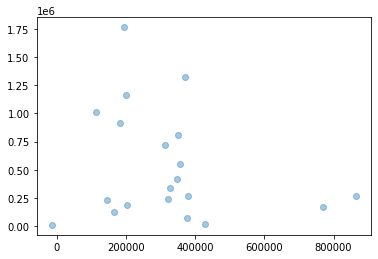

In [ ]:
plt.scatter(pred_y, test_y, alpha = 0.4)
plt.show()

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_true = test_y, y_pred = pred_y)
print('R2 = ', r2)

R2 =  -0.5453785140020209


Selecting Variable by ML

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_features = scaler.fit_transform(x_pp)
test_features = scaler.transform(test_p)

In [ ]:
# Network 구조 형성
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers

from tensorflow.keras.layers import Dropout

In [ ]:
import random
r2 = 0
batch_list = []
learning_list = []
drop_list = []
r2_list = []
model_size = []

T=30
for t in range(T):
  i=0
  batch = random.randint(0,10)
  batch_list.append(batch)
  learning_rate = 10**random.randint(-5,-1)*random.randint(1,9)
  learning_list.append(learning_rate)
  epochs = 300
  drop = 0.01*random.randint(1,50)
  drop_list.append(drop)

  tf.random.set_seed(i)

  model = models.Sequential() # ANN 형성
  fin = random.randint(2,10)
  model_size.append(fin)

  for t in range(1,int(fin/2)):
    model.add(layers.Dense(8*2**t, activation = 'relu', input_shape=(train_features.shape[1],)))
    model.add(Dropout(drop))

  for t in range(int(fin/2),1,-1):
    model.add(layers.Dense(8*2**t, activation = 'relu', input_shape=(train_features.shape[1],)))
    model.add(Dropout(drop))

  model.add(layers.Dense(1))
  i = i+1
   
  print(f"{i}th : batch = {batch}, learing rate = {learning_rate}, drop = {drop}")
  adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=adam, loss='mse', metrics=['mape'])
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True) # Early stopping
  lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=learning_rate) # learning rate 관련

  reg_history = model.fit(train_features, train_y, epochs=epochs, batch_size=batch, validation_split=0.2,
                        callbacks=[es,lr])
  
  y_pred = model.predict(test_features)
  print(f"r2 score : {r2}")
  r2 = r2_score(test_y, y_pred)
  r2_list.append(r2)

newList = [x for x in r2_list if x>0]
newList



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
4/4 [==============================] - 0s 21ms/step - loss: 256186712064.0000 - mape: 99.9747 - val_loss: 91420917760.0000 - val_mape: 99.9809 - lr: 0.0800
Epoch 245/300
4/4 [==============================] - 0s 32ms/step - loss: 256186417152.0000 - mape: 99.9746 - val_loss: 91420712960.0000 - val_mape: 99.9808 - lr: 0.0800
Epoch 246/300
4/4 [==============================] - 0s 27ms/step - loss: 256186105856.0000 - mape: 99.9745 - val_loss: 91420499968.0000 - val_mape: 99.9807 - lr: 0.0800
Epoch 247/300
4/4 [==============================] - 0s 27ms/step - loss: 256185729024.0000 - mape: 99.9744 - val_loss: 91420311552.0000 - val_mape: 99.9807 - lr: 0.0800
Epoch 248/300
4/4 [==============================] - 0s 25ms/step - loss: 256185384960.0000 - mape: 99.9743 - val_loss: 91420131328.0000 - val_mape: 99.9806 - lr: 0.0800
Epoch 249/300
4/4 [==============================] - 0s 23ms/step - loss: 256185122816.0000 - mape: 99.9742 - val_loss: 91419934

[]

In [ ]:
print(max(r2_list))

-0.25235123472941834


모델 추출

In [ ]:
ind = r2_list.index(max(r2_list))
print(ind)
batch = batch_list[ind]
learning_rate = learning_list[ind]
drop = drop_list[ind]
size = model_size[ind]
epochs = 300

print(batch, learning_rate, drop, size)

25
1 0.09 0.05 8


In [ ]:
model = models.Sequential()

model.add(layers.Dense(16, activation = 'relu', input_shape=(train_features.shape[1],)))
model.add(Dropout(drop))
model.add(layers.Dense(32, activation = 'relu', input_shape=(train_features.shape[1],)))
model.add(Dropout(drop))
model.add(layers.Dense(64, activation = 'relu', input_shape=(train_features.shape[1],)))
model.add(Dropout(drop))
model.add(layers.Dense(128, activation = 'relu', input_shape=(train_features.shape[1],)))
model.add(Dropout(drop))
model.add(layers.Dense(128, activation = 'relu', input_shape=(train_features.shape[1],)))
model.add(Dropout(drop))
model.add(layers.Dense(64, activation = 'relu', input_shape=(train_features.shape[1],)))
model.add(Dropout(drop))
model.add(layers.Dense(32, activation = 'relu', input_shape=(train_features.shape[1],)))
model.add(Dropout(drop))
model.add(layers.Dense(16, activation = 'relu', input_shape=(train_features.shape[1],)))
model.add(Dropout(drop))

model.add(layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_272 (Dense)           (None, 16)                112       
                                                                 
 dropout_208 (Dropout)       (None, 16)                0         
                                                                 
 dense_273 (Dense)           (None, 32)                544       
                                                                 
 dropout_209 (Dropout)       (None, 32)                0         
                                                                 
 dense_274 (Dense)           (None, 64)                2112      
                                                                 
 dropout_210 (Dropout)       (None, 64)                0         
                                                                 
 dense_275 (Dense)           (None, 128)             

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adam, loss='mse', metrics=['mape'])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True) # Early stopping
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=learning_rate) # learning rate 관련

reg_history = model.fit(train_features, train_y, epochs=epochs, batch_size=batch, validation_split=0.2,
                        callbacks=[es,lr])
  
y_pred = model.predict(test_features)

Epoch 1/300
35/35 [==============================] - 2s 15ms/step - loss: 422954205184.0000 - mape: 181.0040 - val_loss: 103180181504.0000 - val_mape: 109.1037 - lr: 0.0900
Epoch 2/300
35/35 [==============================] - 0s 7ms/step - loss: 257528250368.0000 - mape: 101.2143 - val_loss: 91469864960.0000 - val_mape: 99.9989 - lr: 0.0900
Epoch 3/300
35/35 [==============================] - 0s 7ms/step - loss: 268207226880.0000 - mape: 134.2412 - val_loss: 44357246976.0000 - val_mape: 59.8517 - lr: 0.0900
Epoch 4/300
35/35 [==============================] - 0s 8ms/step - loss: 222561042432.0000 - mape: 92.0526 - val_loss: 45296906240.0000 - val_mape: 65.1401 - lr: 0.0900
Epoch 5/300
35/35 [==============================] - 0s 7ms/step - loss: 141784678400.0000 - mape: 114.1570 - val_loss: 7043376218112.0000 - val_mape: 523.2019 - lr: 0.0900
Epoch 6/300
35/35 [==============================] - 0s 8ms/step - loss: 1487099002880.0000 - mape: 159.3563 - val_loss: 89109856256.0000 - val_m

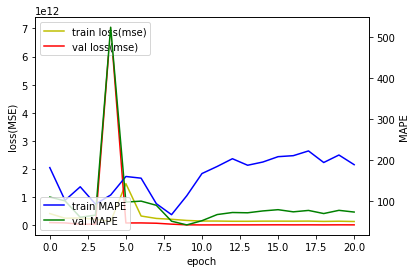

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(reg_history.history['loss'],'y',label='train loss(mse)')
loss_ax.plot(reg_history.history['val_loss'],'r',label='val loss(mse)')
acc_ax.plot(reg_history.history['mape'],'b',label='train MAPE')
acc_ax.plot(reg_history.history['val_mape'],'g',label='val MAPE')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss(MSE)')
acc_ax.set_ylabel('MAPE')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

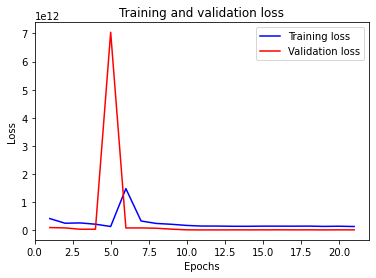

In [ ]:
# 훈련과 검증 손실 (loss)
import matplotlib.pyplot as plt
reg_history_dict = reg_history.history
loss = reg_history_dict['loss']
val_loss = reg_history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss', color='red') # ‘b’는 실선으로, 'bo'는 점으로 나옴
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

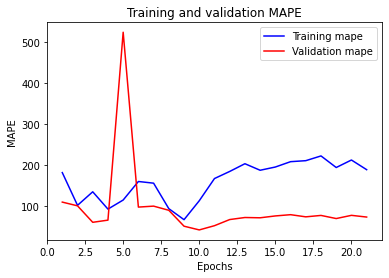

In [ ]:
# 훈련과 검증 MAPE (metric)
plt.clf() # 그래프를 초기화합니다.
train_metric = reg_history_dict['mape']
val_metric = reg_history_dict['val_mape']

plt.plot(epochs, train_metric, 'b', label='Training mape')
plt.plot(epochs, val_metric, label='Validation mape', color='red')
plt.title('Training and validation MAPE')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()

plt.show()

In [ ]:
# 예측
y_pred = model.predict(test_features)

In [ ]:
# 성능평가
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
print('test R squared: %.3f' % r2_score(test_y, y_pred))
print('test MSE: %.3f' % mean_squared_error(test_y,y_pred))
print('tset MAPE: %.3f' % mean_absolute_percentage_error(test_y,y_pred))

test R squared: -0.339
test MSE: 307153506216.323
tset MAPE: 2.490


주요 변수 확인

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

In [ ]:
# MAPE
def mean_absolute_percentage_error(test_y, y_pred):
    test_y, y_pred = np.array(test_y), np.array(y_pred)
    return np.mean(np.abs((test_y - y_pred) / test_y)) * 100

In [ ]:
result = permutation_importance(model, train_features, train_y, scoring = make_scorer(mean_absolute_percentage_error,greater_is_better=False),
                            n_repeats=30,
                            random_state=0)
# Feature label
Feature = x_pp

# Feature 중요도를 오름차순으로 정렬한 뒤, 해당 Feature 의 index 를 저장
sorted_result = result.importances_mean.argsort()

# 결과를 DataFrame
importances = pd.DataFrame(result.importances_mean[sorted_result], index=Feature.columns[sorted_result]).sort_values(0, ascending=False)   
importances

0
PC1  0.0
PC2  0.0
PC3  0.0
PC4  0.0
PC5  0.0
PC6  0.0